In [ ]:
!rm -rf /content/sample_data

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=6ee41f16620a507fa737b026e297f14617d5320d25c94a22373adcd6b12d3c65
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torchvision import models, transforms
import pickle
import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)

cuda


In [ ]:
!mkdir -p /content/kaggle/input
%cd /content/kaggle/input

/content/kaggle/input


In [ ]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle/input/"
os.environ['KAGGLE_USERNAME'] = "ehzawad"
os.environ['KAGGLE_KEY'] = "79f3db3d7153fcea7b7321ad6114c9dd"

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [01:44<00:00, 75.0MB/s]
100% 9.51G/9.51G [01:44<00:00, 97.6MB/s]


In [ ]:
!unzip /content/kaggle/input/aptos2019-blindness-detection.zip -d /content/kaggle/input

Streaming output truncated to the last 5000 lines.
  inflating: /content/kaggle/input/test_images/512beaada8f0.png  
  inflating: /content/kaggle/input/test_images/51323e9d2070.png  
  inflating: /content/kaggle/input/test_images/515675001b9e.png  
  inflating: /content/kaggle/input/test_images/515877da2def.png  
  inflating: /content/kaggle/input/test_images/5168ddccea88.png  
  inflating: /content/kaggle/input/test_images/5172c056a687.png  
  inflating: /content/kaggle/input/test_images/5177461f5339.png  
  inflating: /content/kaggle/input/test_images/51910bcb980d.png  
  inflating: /content/kaggle/input/test_images/51a3e9b6a1c0.png  
  inflating: /content/kaggle/input/test_images/51bbd82feec8.png  
  inflating: /content/kaggle/input/test_images/51de5fb8eccd.png  
  inflating: /content/kaggle/input/test_images/51e88694c81f.png  
  inflating: /content/kaggle/input/test_images/51f0bf8f1544.png  
  inflating: /content/kaggle/input/test_images/51f57fb32840.png  
  inflating: /content/kag

In [ ]:
path = "/content/kaggle/input/"

train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(f'{path}test.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 3662
No.of.testing_samples: 1928


In [ ]:
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1,2,3,4]), y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
 
print(class_weights) 

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


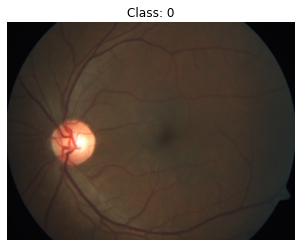

In [ ]:
num = int(np.random.randint(0, len(train_df)-1, (1, )))
sample_image = (f'{path}train_images/{train_df["id_code"][num]}.png')
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}')
plt.show()

In [ ]:
class dataset(Dataset):     
    def __init__(self, df, data_path, image_transform=None, train=True): 
        super(Dataset,self).__init__() 
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') 
        if self.image_transform :
            image = self.image_transform(image) 
        
        if self.train :
            label = self.df['diagnosis'][index]
            return image, label 
        
        else:
            return image 
            

In [ ]:
image_transform = transforms.Compose([transforms.Resize([512, 512]),
                                      transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
data_set = dataset(train_df, f'{path}train_images', image_transform=image_transform)
train_set, valid_set = torch.utils.data.random_split(data_set, [3302,360])

In [ ]:
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True) 
valid_dataloader = DataLoader(valid_set, batch_size=32, shuffle=True)

In [ ]:
# len(train_dataloader.dataset.indices)
len(valid_dataloader.dataset.indices)

360

In [ ]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, nb_classes=10):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # Remove last linear layer
        self.modelA.fc = nn.Linear(512, nb_classes)

        # self.modelB.classifier = nn.Linear(1024, nb_classes)
        self.modelB.classifier[6] = nn.Linear(4096, nb_classes)

        # Create new classifier
        self.classifier = nn.Linear(10, nb_classes)

    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)

        x = self.classifier(F.relu(x))
        return x


modelA = models.resnet18(pretrained=True)
# modelB = models.densenet121(pretrained=True)
modelB = models.vgg16(pretrained=True)

# Freeze these models
for param in modelA.parameters():
    param.requires_grad_(False)

for param in modelB.parameters():
    param.requires_grad_(False)

# Create ensemble model
model = MyEnsemble(modelA, modelB, 5)
# x = torch.randn(1, 3, 224, 224)
# output = model(x)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
import torch.nn.utils.prune as prune

In [ ]:
model = model.to(device)

In [ ]:
def pruning(proportion):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=proportion)
            # If you want to remove a module, just assign a module to a variable r and then call prune.remove(r)
        elif isinstance(module, torch.nn.Conv1d):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.BatchNorm2d):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.BatchNorm1d):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.CrossEntropyLoss):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.Flatten):
            prune.l1_unstructured(module, name='weight', amount=proportion)
        elif isinstance(module, torch.nn.InstanceNorm1d):
            prune.l1_unstructured(module, name='weight', amount=proportion)

In [ ]:
pruning(.1)

In [ ]:
print(list(model.named_buffers()))

[('modelA.conv1.weight_mask', tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1

In [ ]:
model = model.to(device)

In [ ]:
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):

    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [ ]:
def measure_global_sparsity(model,
                            weight=True,
                            bias=True,
                            conv2d_use_mask=True,
                            conv1d_use_mask=True,
                            linear_use_mask=True,
                            batchnorm1_use_mask=True,
                            batchnorm2_use_mask=True,
                            crossEntropy_use_mask=True,
                            flatten_use_mask=True,
                            instanceNorm1_use_mask=True): 
    num_zeros = 0
    num_elements = 0



    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Conv1d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv1d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.BatchNorm1d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=batchnorm1_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.BatchNorm2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=batchnorm2_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements



        elif isinstance(module, torch.nn.CrossEntropyLoss):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=crossEntropy_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements


        elif isinstance(module, torch.nn.Flatten):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=flatten_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

     
        elif isinstance(module, torch.nn.InstanceNorm1d):
            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
              module, weight=weight, bias=bias, use_mask=instanceNorm1_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements
    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [ ]:
num_zeros, num_elements, sparsity = measure_global_sparsity(
            model,
            weight=True,
            bias=True,
            conv2d_use_mask=True,
            conv1d_use_mask=True,
            linear_use_mask=True,
            batchnorm1_use_mask=True,
            batchnorm2_use_mask=True,
            crossEntropy_use_mask=True,
            flatten_use_mask=True,
            instanceNorm1_use_mask=True)
 



In [ ]:
print(num_zeros)
print(num_elements)
print(sparsity)

14544295
145442930
0.10000001375109811


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total = 0
    correct = 0
    running_loss = 0
    trainingAccuracy = 0
    
    for batch in tqdm(dataloader):       
        x = batch[0]
        y = batch[1]
        output = model(x.to(device)) 
        loss   = loss_fn(output, y.to(device))
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach()
        correct      += (predictions == y.cpu().detach()).sum().item()

        
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()
             
    
    avg_loss = running_loss/len(dataloader)

    training_accuracy = 100*(correct/total)

    print(f'\nTraining Loss = {avg_loss:.6f}', end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]')
    
    return avg_loss, training_accuracy

In [ ]:
def validate(dataloader,model,loss_fn): 
    model.eval()     
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad():  
        for x,y in dataloader:
            
            output        = model(x.to(device)) 
            loss          = loss_fn(output, y.to(device)).item()
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader)     
    validation_accuracy = 100*(correct/total)

    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]')
      
    return avg_loss, validation_accuracy

In [ ]:
def optimize(train_dataloader, valid_dataloader, model, loss_fn, optimizer, nb_epochs):
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []
    best_valid_acc = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss, train_accuracy = train(train_dataloader, model, loss_fn ,optimizer)
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)
        valid_loss, validation_accuracy = validate(valid_dataloader, model, loss_fn)
        valid_losses.append(valid_loss)
        valid_acc.append(validation_accuracy)

       
    
    print('\nunstructed_pruning_for_sparsity Training has completed!')
    return train_losses, valid_losses, train_acc, valid_acc

In [ ]:
from tqdm.notebook import tqdm
loss_fn   = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) 
nb_epochs = 20

train_losses, valid_losses, train_acc, valid_acc = optimize(train_dataloader, valid_dataloader, model, loss_fn, optimizer, nb_epochs)


Epoch 1/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Training Loss = 1.565980	Accuracy on Training set = 41.429437% [1368/3302]

Validation Loss = 1.487170	Accuracy on Validation set = 52.222222% [188/360]

Epoch 2/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.446558	Accuracy on Training set = 57.298607% [1892/3302]

Validation Loss = 1.385244	Accuracy on Validation set = 57.500000% [207/360]

Epoch 3/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.354591	Accuracy on Training set = 61.992732% [2047/3302]

Validation Loss = 1.316011	Accuracy on Validation set = 64.166667% [231/360]

Epoch 4/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.293149	Accuracy on Training set = 65.505754% [2163/3302]

Validation Loss = 1.275002	Accuracy on Validation set = 68.333333% [246/360]

Epoch 5/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.237034	Accuracy on Training set = 64.324652% [2124/3302]

Validation Loss = 1.234288	Accuracy on Validation set = 68.888889% [248/360]

Epoch 6/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.197583	Accuracy on Training set = 67.534827% [2230/3302]

Validation Loss = 1.205225	Accuracy on Validation set = 64.166667% [231/360]

Epoch 7/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.163949	Accuracy on Training set = 66.959419% [2211/3302]

Validation Loss = 1.167820	Accuracy on Validation set = 71.388889% [257/360]

Epoch 8/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.132348	Accuracy on Training set = 66.989703% [2212/3302]

Validation Loss = 1.144824	Accuracy on Validation set = 66.111111% [238/360]

Epoch 9/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.106953	Accuracy on Training set = 68.715930% [2269/3302]

Validation Loss = 1.160532	Accuracy on Validation set = 66.111111% [238/360]

Epoch 10/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.090079	Accuracy on Training set = 67.625681% [2233/3302]

Validation Loss = 1.108520	Accuracy on Validation set = 68.888889% [248/360]

Epoch 11/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.070333	Accuracy on Training set = 68.503937% [2262/3302]

Validation Loss = 1.090694	Accuracy on Validation set = 67.777778% [244/360]

Epoch 12/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.052307	Accuracy on Training set = 68.715930% [2269/3302]

Validation Loss = 1.084367	Accuracy on Validation set = 72.222222% [260/360]

Epoch 13/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.049584	Accuracy on Training set = 69.866747% [2307/3302]

Validation Loss = 1.007058	Accuracy on Validation set = 72.777778% [262/360]

Epoch 14/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.027383	Accuracy on Training set = 70.109025% [2315/3302]

Validation Loss = 1.076172	Accuracy on Validation set = 71.388889% [257/360]

Epoch 15/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.033869	Accuracy on Training set = 70.926711% [2342/3302]

Validation Loss = 1.039434	Accuracy on Validation set = 70.555556% [254/360]

Epoch 16/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.005819	Accuracy on Training set = 71.138704% [2349/3302]

Validation Loss = 1.016764	Accuracy on Validation set = 70.555556% [254/360]

Epoch 17/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 1.000404	Accuracy on Training set = 70.775288% [2337/3302]

Validation Loss = 1.037997	Accuracy on Validation set = 73.611111% [265/360]

Epoch 18/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 0.986836	Accuracy on Training set = 71.592974% [2364/3302]

Validation Loss = 1.029554	Accuracy on Validation set = 73.055556% [263/360]

Epoch 19/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 0.989559	Accuracy on Training set = 71.229558% [2352/3302]

Validation Loss = 1.063767	Accuracy on Validation set = 71.388889% [257/360]

Epoch 20/20
-------------------------------


  0%|          | 0/104 [00:00<?, ?it/s]


Training Loss = 0.985546	Accuracy on Training set = 70.866142% [2340/3302]

Validation Loss = 1.045007	Accuracy on Validation set = 73.055556% [263/360]

unstructed_pruning_for_conv2_layer_sparsity Training has completed!


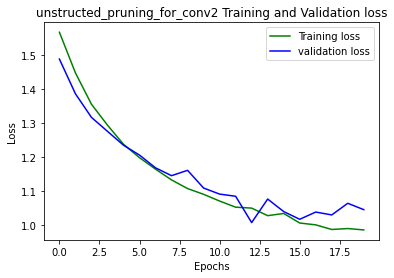

In [ ]:
epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('unstructed_Pruned_Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("unstructed_pruned_Training and validation.png")
plt.show()

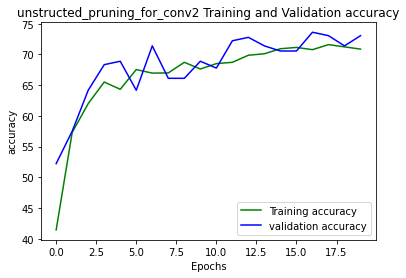

In [ ]:
epochs = range(nb_epochs)
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, valid_acc, 'b', label='validation accuracy')
plt.title('unstructed_pruning_for_Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("unstructed_pruning_for_traning_validation_ACCURACY.png")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support

def luate(dataloader,model_pass,loss_fn): 
    model_pass.eval()     
    total = 0
    correct = 0
    running_loss = 0
    actual_label_list = []
    predicted_label_list = []

    with torch.no_grad():  
        for x,y in dataloader:
            
            output        = model_pass(x.to(device)) 
            loss          = loss_fn(output, y.to(device)).item()
            running_loss += loss
          
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()

            actual_label_list.append(y.cpu().detach().tolist())
            predicted_label_list.append(predictions.tolist())
            
    avg_loss = running_loss/len(dataloader)     
    validation_accuracy = 100*(correct/total)

    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]')

    actual_labels = [item for sublist in actual_label_list  for item in sublist]
    predicted_labels = [item for sublist in predicted_label_list  for item in sublist]

    acc = accuracy_score(actual_labels, predicted_labels)
    p, r, f1, _ = precision_recall_fscore_support(actual_labels,  predicted_labels, average='macro')
    kappa = cohen_kappa_score(actual_labels, predicted_labels)

    # print('Acc: ' + str(acc*100)+'%')
    # print('Precision: ' + str(p*100)+'%')
    # print('Recall: ' + str(r*100)+'%')
    # print('F1 score: ' + str(f1*100)+'%')
    # print('Kappa score: ' + str(kappa*100)+'%')

    return avg_loss

def prune_model(model_pass, layer_type, proportion):
    for name, module in model_pass.named_modules():
        if isinstance(module, layer_type):
            prune.l1_unstructured(module, 'weight', proportion)
            prune.remove(module, 'weight')
    return model_pass

def prune_model_l1_unstructured(model_pass, layer_type, proportion):
    for module in model_pass.modules():
        if isinstance(module, layer_type):
            prune.l1_unstructured(module, 'weight', proportion)
            # prune.remove(module, 'weight')
    return model_pass

def test_pruning_jobs(model_pass, prune_fn, eval_fn):
    losses = []
    
    print(f"Evaluating model with θ=0 pruning.")
    
    unpruned_loss = luate(valid_dataloader, model_pass, loss_fn)
    losses.append((0, unpruned_loss))
    
    for i in range(1, 18):
        p = i * 0.05
        print(f"Evaluating model with θ={p} pruning.")
   
        pruned_model = prune_fn(model_pass, p)
        loss = luate(valid_dataloader, pruned_model, loss_fn)
        losses.append((p, loss))
    
    return losses


In [ ]:
# model_picked_for_unstructured_pruning = model
# model_picked_for_structured_pruning = model
# model_picked_for_global_unstructured_pruning = model


In [ ]:
# if model_picked_for_global_unstructured_pruning == model_picked_for_structured_pruning:
#   print('yes')

yes


In [ ]:
# if model_picked_for_structured_pruning == model_picked_for_global_unstructured_pruning:
#   print('yes')

yes


In [ ]:
# prune_fn = lambda model_picked_for_unstructured_pruning, proportion: prune_model(model_picked_for_unstructured_pruning, nn.Conv2d, proportion)

# losses = test_pruning_jobs(model_picked_for_unstructured_pruning, prune_fn, luate)
# print(losses)

Evaluating model with θ=0 pruning.

Validation Loss = 1.045272	Accuracy on Validation set = 72.222222% [260/360]
Evaluating model with θ=0.05 pruning.

Validation Loss = 1.039998	Accuracy on Validation set = 70.555556% [254/360]
Evaluating model with θ=0.1 pruning.

Validation Loss = 1.010817	Accuracy on Validation set = 70.555556% [254/360]
Evaluating model with θ=0.15000000000000002 pruning.

Validation Loss = 1.022870	Accuracy on Validation set = 69.444444% [250/360]
Evaluating model with θ=0.2 pruning.

Validation Loss = 1.015569	Accuracy on Validation set = 68.888889% [248/360]
Evaluating model with θ=0.25 pruning.

Validation Loss = 1.007331	Accuracy on Validation set = 71.666667% [258/360]
Evaluating model with θ=0.30000000000000004 pruning.

Validation Loss = 1.045369	Accuracy on Validation set = 69.444444% [250/360]
Evaluating model with θ=0.35000000000000003 pruning.

Validation Loss = 1.059112	Accuracy on Validation set = 71.111111% [256/360]
Evaluating model with θ=0.4 prun

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Loss = 1.841981	Accuracy on Validation set = 35.555556% [128/360]
Evaluating model with θ=0.8 pruning.

Validation Loss = 1.848440	Accuracy on Validation set = 26.388889% [95/360]
Evaluating model with θ=0.8500000000000001 pruning.

Validation Loss = 2.100399	Accuracy on Validation set = 26.944444% [97/360]
[(0, 1.0452720026175182), (0.05, 1.03999828795592), (0.1, 1.010817031065623), (0.15000000000000002, 1.0228703419367473), (0.2, 1.0155694633722305), (0.25, 1.0073313117027283), (0.30000000000000004, 1.0453685025374095), (0.35000000000000003, 1.0591121067603428), (0.4, 1.0680384784936905), (0.45, 1.2196924189726512), (0.5, 1.3380711326996486), (0.55, 1.4236207405726116), (0.6000000000000001, 1.3831888337930043), (0.65, 1.7325624823570251), (0.7000000000000001, 1.6936885217825572), (0.75, 1.841980571548144), (0.8, 1.8484397530555725), (0.8500000000000001, 2.100399156411489)]


In [ ]:
pd.DataFrame.assign

<function pandas.core.frame.DataFrame.assign>

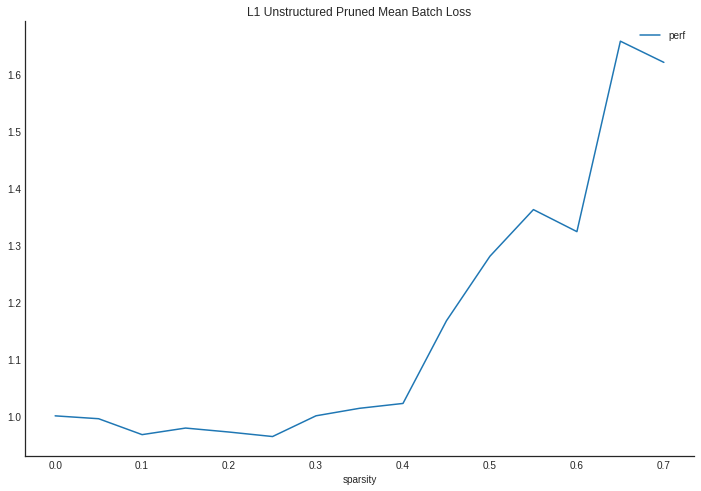

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.style.use('seaborn-white')

# import pandas as pd
# (pd.DataFrame(losses, columns=['sparsity', 'loss'])
#  .pipe(lambda df: df.assign(
#      perf=(df.loss - pd.Series([losses[0][1]] * len(df))) / losses[0][1] + 1
#  ))
#  .head(15)
#  .plot.line(x='sparsity', y='perf', figsize=(12, 8), title="L1 Unstructured Pruned Mean Batch Loss").figure.savefig('L1 Unstructured Pruned Mean Batch Loss.png')
# )
# sns.despine()


In [ ]:
# def prune_model_l1_structured(model, layer_type, proportion):
#     """
#     Prunes the model.
#     """
#     for name, module in model.named_modules():
#         if isinstance(module, layer_type):
#             prune.ln_structured(module, 'weight', proportion, n=1, dim=1)
#             prune.remove(module, 'weight')
#     return model

# prune_fn = lambda model_picked_for_structured_pruning, proportion: prune_model_l1_structured(model_picked_for_structured_pruning, nn.Conv2d, proportion)


In [ ]:
# %%time
# losses = test_pruning_jobs(model_picked_for_structured_pruning, prune_fn, luate)
# print(losses)

Evaluating model with θ=0 pruning.

Validation Loss = 2.205681	Accuracy on Validation set = 26.944444% [97/360]
Evaluating model with θ=0.05 pruning.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Loss = 2.021984	Accuracy on Validation set = 26.944444% [97/360]
Evaluating model with θ=0.1 pruning.

Validation Loss = 1.935682	Accuracy on Validation set = 27.222222% [98/360]
Evaluating model with θ=0.15000000000000002 pruning.

Validation Loss = 2.808149	Accuracy on Validation set = 42.222222% [152/360]
Evaluating model with θ=0.2 pruning.

Validation Loss = 5.011180	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.25 pruning.

Validation Loss = 3.852965	Accuracy on Validation set = 44.722222% [161/360]
Evaluating model with θ=0.30000000000000004 pruning.

Validation Loss = 6.868409	Accuracy on Validation set = 48.611111% [175/360]
Evaluating model with θ=0.35000000000000003 pruning.

Validation Loss = 10.308428	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.4 pruning.

Validation Loss = 5.562526	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.45 pruning.

Validation Loss = 6.359793	Acc

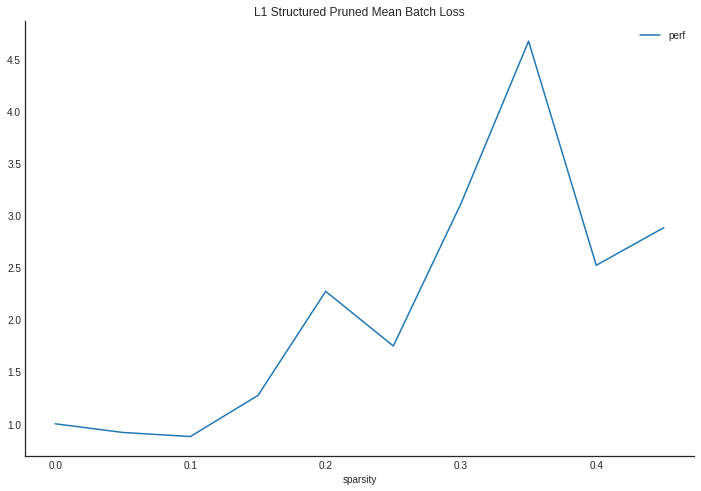

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.style.use('seaborn-white')

# import pandas as pd
# (pd.DataFrame(losses, columns=['sparsity', 'loss'])
#  .pipe(lambda df: df.assign(
#      perf=(df.loss - pd.Series([losses[0][1]] * len(df))) / losses[0][1] + 1
#  ))
#  .head(10)
#  .plot.line(x='sparsity', y='perf', figsize=(12, 8), title="L1 Structured Pruned Mean Batch Loss").figure.savefig('L1 Structured Pruned Mean Batch Loss.png')
# )
# sns.despine()

In [ ]:
# def prune_model_global_unstructured(model, layer_type, proportion):
#     module_tups = []
#     for module in model.modules():
#         if isinstance(module, layer_type):
#             module_tups.append((module, 'weight'))

#     prune.global_unstructured(
#         parameters=module_tups, pruning_method=prune.L1Unstructured,
#         amount=proportion
#     )
#     for module, _ in module_tups:
#         prune.remove(module, 'weight')
#     return model

# prune_fn = lambda model_picked_for_global_unstructured_pruning, proportion: prune_model_global_unstructured(model_picked_for_unstructured_pruning, nn.Conv2d, proportion)


In [ ]:
# %%time
# losses = losses = test_pruning_jobs(model_picked_for_global_unstructured_pruning, prune_fn, luate)
# print(losses)


Evaluating model with θ=0 pruning.

Validation Loss = 2.205648	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.05 pruning.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Loss = 2.241503	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.1 pruning.

Validation Loss = 2.220891	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.15000000000000002 pruning.

Validation Loss = 2.128542	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.2 pruning.

Validation Loss = 2.233214	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.25 pruning.

Validation Loss = 2.227745	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.30000000000000004 pruning.

Validation Loss = 2.241727	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.35000000000000003 pruning.

Validation Loss = 2.260367	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.4 pruning.

Validation Loss = 2.140172	Accuracy on Validation set = 48.333333% [174/360]
Evaluating model with θ=0.45 pruning.

Validation Loss = 2.145189	Ac